In [11]:
import os
import pandas as pd
from util import set_seed

RANDOM_STATE = 42
set_seed(RANDOM_STATE)
current_dir = os.getcwd()
final_path = os.path.join(current_dir, '..', 'data', 'final', 'final.csv')
selected_path = os.path.join(current_dir, '..', 'data', 'final', 'selected.csv')

final_df = pd.read_csv(final_path)
selected_df = pd.read_csv(selected_path).drop(columns=['user_id']).values

### Przygotowanie danych

In [12]:
from sklearn.model_selection import train_test_split

y = final_df['premium_user'].values

X_train, X_test, y_train, y_test = train_test_split(selected_df, y, test_size=0.2, random_state=42)

### Klasyfikator SVM

Szukanie parametrów

In [13]:
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

param_dist  = {
    'C': np.logspace(-3, 3, 10),
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']
}

svc = SVC(probability=True)

random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_dist,
    n_iter=25,
    cv=2,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    scoring='roc_auc'
)
random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)

Fitting 2 folds for each of 25 candidates, totalling 50 fits
Best parameters found:  {'kernel': 'rbf', 'gamma': 'scale', 'C': 2.154434690031882}
Best cross-validation score:  0.8677919020131267


Uczenie

In [15]:
clf = SVC(kernel='rbf', probability=True, gamma='scale', C=2.15, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

Accuracy: 0.80
ROC AUC: 0.86
Precision: 0.82
Recall: 0.66
F1 Score: 0.73


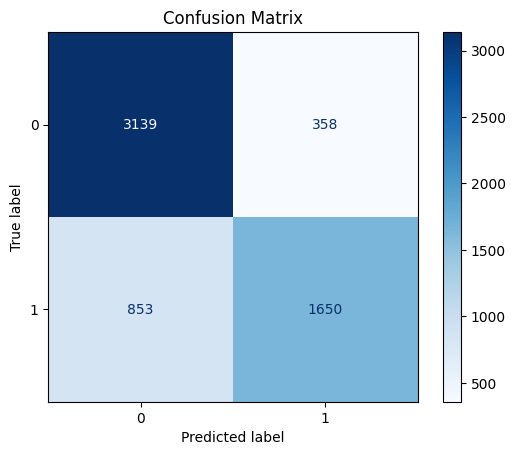

In [16]:
from util import show_metrics

show_metrics(y_test, y_pred, y_pred_proba)

Save models

In [17]:
import joblib

model_path = os.path.join(current_dir, 'trained', 'svm_selected_model.joblib')

joblib.dump(clf, model_path)

['d:\\_prog\\Projekty\\Account-Classifier\\models\\trained\\svm_selected_model.joblib']